### Hyper-parameter optimization con Optuna

In [41]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import pickle

import optuna

%matplotlib inline

In [2]:
data = pd.read_csv('cs-training-nonull.csv')

# remove unneeded
data = data.drop('id', axis = 1)

In [3]:
# global constants
N_ESTIMATORS = 500
# numero di features compreso le due colonne indicatore aggiunte
N_FEATURES = 12

# nome della colonna con le label
TARGET = 'SeriousDlqin2yrs'

# colonne con missing values
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

# nomi delle due colonne indicator (valgono 1 laddove il dato è inputato)
IND1 = 'isna_mi'
IND2 = 'isna_nod'
ind_col = [IND1, IND2]

# prese da stats sul train test, usate per inputare i missing values su COL1 e CL2
MONTHLY_INC_MEDIAN = 5400.0
N_OF_DEP_MODE = 0

In [4]:
# split in train, validation set
def split_train_test(df, ratio):
    # shuffle before split
    df = df.sample(frac = 1)
    N_REC = df.shape[0]
    N_TRAIN = int(N_REC * ratio)
    N_VALID = N_REC - N_TRAIN
    train_df = df[:N_TRAIN]
    valid_df = df[N_TRAIN:]
    
    return train_df, valid_df

In [5]:
train_df, valid_df = split_train_test(data, 0.8)

In [6]:
# metto da parte le due colonne indicatori
ind_train = train_df[ind_col].values
ind_valid = valid_df[ind_col].values

In [7]:
train_df = train_df.drop(ind_col, axis = 1)
valid_df = valid_df.drop(ind_col, axis = 1)

# estrae X: matrice features ed y, labels
y_train = train_df[TARGET].values
xtrain_df = train_df.drop(TARGET, axis = 1)
x_train = xtrain_df.values

y_valid = valid_df[TARGET].values
xvalid_df = valid_df.drop(TARGET, axis = 1)
x_valid = xvalid_df.values

In [8]:
# prepara lo scaling
scaler = StandardScaler()

# calcola i parametri di scaling solo sul train set
scaler.fit(x_train)

StandardScaler()

In [9]:
# scalo tutto tranne che le due colonne indicatore
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

In [10]:
# riaggiungo gli indicatori (che non vengono scalati)
x_train_scaled = np.c_[x_train_scaled, ind_train]
x_valid_scaled = np.c_[x_valid_scaled, ind_valid]

In [11]:
# check
assert x_train_scaled.shape[1] == N_FEATURES
assert x_valid_scaled.shape[1] == N_FEATURES

### Train the XGBoost Classifier

In [12]:
def objective(trial):
    param = {'objective':'binary:logistic', 
             'random_state': 0,
             'n_estimators':N_ESTIMATORS,
             'learning_rate':trial.suggest_uniform("learning_rate", 0.001, 0.01), 
             'max_depth': trial.suggest_int('max_depth', 3, 8, 1),
             'min_child_weight': trial.suggest_uniform("min_child_weight", 6.0, 12.0),
             'max_delta_step': trial.suggest_uniform("max_delta_step",1.5, 2.0), 
             'colsample_bytree': trial.suggest_uniform("colsample_bytree", 0.3, 0.6),
             'subsample': trial.suggest_uniform("subsample", 0.5, 0.9), 
             'eta': trial.suggest_uniform("eta", 0.010, 0.050),
             'gamma': trial.suggest_uniform("gamma", 0.50, 0.80)
                 }
    
    clf = xgb.XGBClassifier(use_label_encoder=False, **param)
    
    # addestro e valuto su train e su validation sec
    clf.fit(x_train_scaled, y_train,
        eval_set=[(x_train_scaled, y_train), (x_valid_scaled, y_valid)],
        eval_metric='auc', verbose=False)
    
    evals_result = clf.evals_result()
    
    val_hist = evals_result['validation_1']['auc']
    
    score = val_hist[-1]
    
    return score

In [13]:
study = optuna.create_study(direction='maximize', study_name='credit1')
study.optimize(objective, n_trials=10)

[I 2022-03-14 08:03:13,971] A new study created in memory with name: credit1
[I 2022-03-14 08:04:59,578] Trial 0 finished with value: 0.860854 and parameters: {'learning_rate': 0.009589602124395576, 'max_depth': 4, 'min_child_weight': 8.856700109380128, 'max_delta_step': 1.7429834490739398, 'colsample_bytree': 0.3626184582488109, 'subsample': 0.6719757160078141, 'eta': 0.023192427754631727, 'gamma': 0.6180793738173892}. Best is trial 0 with value: 0.860854.
[I 2022-03-14 08:07:34,913] Trial 1 finished with value: 0.861722 and parameters: {'learning_rate': 0.004300231951003278, 'max_depth': 6, 'min_child_weight': 9.38556771556079, 'max_delta_step': 1.9105821268329686, 'colsample_bytree': 0.5081460868576426, 'subsample': 0.6378562072449082, 'eta': 0.038098841263427316, 'gamma': 0.7140962372341386}. Best is trial 1 with value: 0.861722.
[I 2022-03-14 08:10:31,011] Trial 2 finished with value: 0.859297 and parameters: {'learning_rate': 0.0013805838837134272, 'max_depth': 8, 'min_child_weig

In [14]:
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.862581
  Params: 
    learning_rate: 0.009125082937503245
    max_depth: 5
    min_child_weight: 9.204436969676774
    max_delta_step: 1.7629279475088857
    colsample_bytree: 0.518884264690591
    subsample: 0.5124147516741705
    eta: 0.04112657176431049
    gamma: 0.609580152731253


In [15]:
# settiamo i parametri del best trial
param = {'objective':'binary:logistic', 
             'random_state': 0,
             'n_estimators':N_ESTIMATORS}

print('Running with following parameters:')
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    param[key] = value

clf = xgb.XGBClassifier(use_label_encoder=False, **param)
    
# addestro e valuto su train e su validation sec
clf.fit(x_train_scaled, y_train,
        eval_set=[(x_train_scaled, y_train), (x_valid_scaled, y_valid)],
        eval_metric='auc', verbose=False)
    
evals_result = clf.evals_result()

Running with following parameters:
    learning_rate: 0.009125082937503245
    max_depth: 5
    min_child_weight: 9.204436969676774
    max_delta_step: 1.7629279475088857
    colsample_bytree: 0.518884264690591
    subsample: 0.5124147516741705
    eta: 0.04112657176431049
    gamma: 0.609580152731253


In [18]:
def plot_auc(train_hist, val_hist):
    plt.figure(figsize=(9,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.plot(val_hist, label='Validation AUC')
    plt.title('AUC')
    plt.legend(loc='upper right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

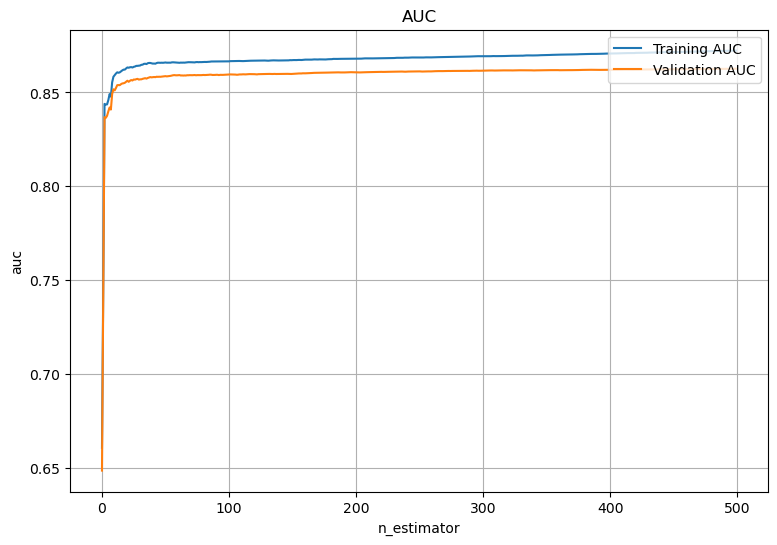

In [19]:
train_hist = evals_result['validation_0']['auc']
val_hist = evals_result['validation_1']['auc']

plot_auc(train_hist, val_hist)

In [20]:
# compute accuracy on validation set
y_pred = clf.predict(x_valid_scaled)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy on validation set: %.2f%%" % (accuracy * 100.0))

Accuracy on validation set: 93.81%


In [21]:
# compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_valid, predictions).ravel()

(tn, fp, fn, tp)

(27807, 179, 1679, 335)

### Prediction on the TEST set (for submission to Kaggle)

In [22]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

# inpute missing values, add the two indicator columns
orig_test['isna_mi'] = 0
orig_test.loc[orig_test[COL1_MISSING].isna(), 'isna_mi'] = 1
orig_test.loc[orig_test[COL1_MISSING].isna(), COL1_MISSING] = MONTHLY_INC_MEDIAN

orig_test['isna_nod'] = 0
orig_test.loc[orig_test[COL2_MISSING].isna(), 'isna_nod'] = 1
orig_test.loc[orig_test[COL2_MISSING].isna(), COL2_MISSING] = N_OF_DEP_MODE

In [23]:
ind_test = orig_test[ind_col].values

In [24]:
orig_test = orig_test.drop(ind_col, axis = 1)

In [25]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)

x_test = xorig_test.values

In [26]:
# aggiungi qui lo scaling !!!
x_test_scaled = scaler.transform(x_test)
# riaggiunge le colonne indicatore
x_test_scaled = np.c_[x_test_scaled, ind_test]

assert x_test_scaled.shape[1] == N_FEATURES

In [27]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test_scaled)

# y_pred contiene le probabilità
y_pred = y_pred[:, 1]

In [28]:
# prepara il csv per la submission
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission25.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')

In [29]:
# save model: uso un formato semplice: pkl
pickle.dump(clf, open("credit-scoring.pkl", "wb"))

In [30]:
# salvo anche lo scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))

### Online predictions

In [31]:
# reload the model
loaded_model = pickle.load(open("credit-scoring.pkl", "rb"))

In [32]:
# reload the scaler
loaded_scaler = pickle.load(open("scaler.pkl", "rb"))

In [34]:
# prepare for online predictions
# input are given as a numpy array, with no missing fields, but we need to add the two indicator columns
x_input = np.array([[1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10]])

In [35]:
# controlli
assert x_input.shape[1] == 10
# check there are no null
assert np.sum(np.isnan(x_input)) == 0

In [36]:
# normalize
x_input_scaled = loaded_scaler.transform(x_input)
# add two columns with 0
x_add = np.zeros((x_input.shape[0], 2))
x_input_scaled = np.c_[x_input_scaled, x_add]

In [37]:
y_pred = loaded_model.predict(x_input_scaled)

In [38]:
y_pred

array([1, 1, 1])

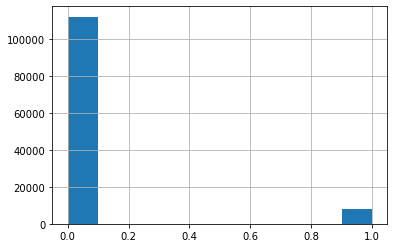

In [42]:
train_df[TARGET].hist();